In [ ]:
import sagemaker

In [2]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [3]:
import boto3
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
model_name = None
model_data = None
image_uri = '{0}.dkr.ecr.{1}.amazonaws.com/all-in-one-ai-stable-diffusion-webui-inference:latest'.format(account_id, region_name)
model_environment = {
    'pretrained':'waifu-diffusion', 'SAGEMAKER_MODEL_SERVER_WORKERS': '1'
}

In [5]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

In [6]:
model = Model(
    name = model_name,
    model_data = model_data,
    role = role,
    image_uri = image_uri,
    env = model_environment,
    predictor_cls = Predictor
)

In [10]:
endpoint_name = None
instance_type = 'ml.g4dn.12xlarge'
instance_count = 1

In [11]:
predictor = model.deploy(
    endpoint_name = endpoint_name,
    instance_type = instance_type, 
    initial_instance_count = instance_count
)

--------------!

In [15]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    'inputs': 'A magical dragon flying in front of the Himalaya in manga style'
}

prediction = predictor.predict(inputs)

In [19]:
s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

In [17]:
bucket, key = get_bucket_and_key(prediction['results'])

In [18]:
print(bucket, key)

sagemaker-ap-east-1-034068151705 stablediffusion/inference/output/9f99746b-fdee-4d78-9bf3-690c6a81e4e9.jpg


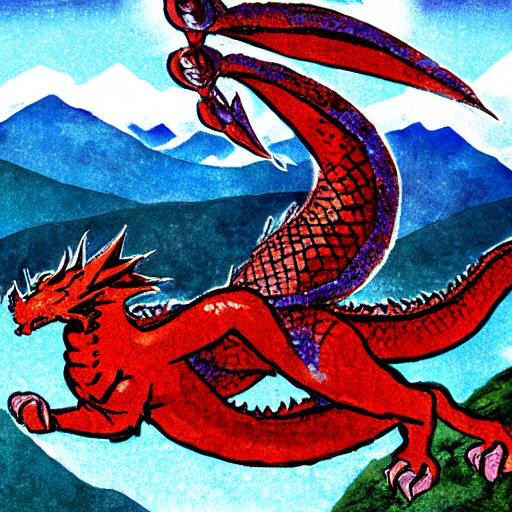

In [26]:
from PIL import Image
import io
obj = s3_resource.Object(bucket, key)
bytes = obj.get()['Body'].read() 
image = Image.open(io.BytesIO(bytes)) 
image.show()

In [ ]:
#predictor.delete_endpoint()